
# **Pneumonia Detection from Chest X-Ray Images Using Deep Learning**



## **Project Objective**

The main Objective of this project is to build a deep learning model using Cnovoloutional Neural Networks (CNNs) to automatically classify Chest X-Ray Images as either Normal or Pneumonia using PyTorch.

The model aims to assist in early detection of Pneumonia by analyzing medical images and learning visual patterns associated with lung infections.

**Image Classification:**

The Trained model receives a chest X-ray image as input and predicts which category the image belongs to, the model classifies each image into one of the following two classes:

Normal --> The lungs appear healthy with no signs of pneumonia

Pneumonia --> The image shows visual patterns associated with lung infection




### **1- Importing the necessary libraries**

In [ ]:
import kagglehub
import os, random, copy, itertools, pathlib, warnings
warnings.filterwarnings('ignore')

from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchsummary import summary

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
torch.set_num_threads(min(8, os.cpu_count()))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)


Device: cpu


### **2- Download Data**

In [ ]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


### **4- Checking the strcture of the data**


In [ ]:
os.listdir(path)


['chest_xray']

In [ ]:
# Check folders
os.listdir(path + "/chest_xray")

['chest_xray', '__MACOSX', 'val', 'test', 'train']

In [ ]:
# Define split folders (already provided by the dataset)
train_dir = path + "/chest_xray/train"
val_dir   = path + "/chest_xray/val"
test_dir  = path + "/chest_xray/test"

print("Train dir:", train_dir)
print("Val dir  :", val_dir)
print("Test dir :", test_dir)


Train dir: /kaggle/input/chest-xray-pneumonia/chest_xray/train
Val dir  : /kaggle/input/chest-xray-pneumonia/chest_xray/val
Test dir : /kaggle/input/chest-xray-pneumonia/chest_xray/test


### **4- Data Merging & Re-Splitting Data (70% Train / 15% Val / 15% Test)**

The original dataset comes with train/val/test folders.
Here we merge all images and then re-split them into:
- **70% Train**
- **15% Validation**
- **15% Test**

We also print the number of samples per class in each split.


**Step 1: merge the train, validation, and test datasets into a single raw dataset without applying any transformations, ensuring a consistent class to idx mapping across all samples.
By doing this, the dataset can be split later in a controlled and reproducible way (e.g., 70/15/15), while allowing different transforms to be applied to the same samples for training and evaluation .**

In [ ]:
# Merge (train + val + test) into one dataset (same label mapping)

train_raw = ImageFolder(train_dir, transform=None)
val_raw   = ImageFolder(val_dir,   transform=None)
test_raw  = ImageFolder(test_dir,  transform=None)

classes = train_raw.classes
class_to_idx = train_raw.class_to_idx
print("Classes:", classes)
print("class_to_idx:", class_to_idx)

all_samples = train_raw.samples + val_raw.samples + test_raw.samples
all_targets = [y for _, y in all_samples]

class MergedChestXrayDataset(Dataset):
    def __init__(self, samples, targets, loader, transform=None):
        self.samples = samples
        self.targets = targets
        self.loader = loader
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, _ = self.samples[idx]
        y = self.targets[idx]
        x = self.loader(path)
        if self.transform:
            x = self.transform(x)
        return x, y

# We'll create two views of the same merged data:
# - one with train_transform (augmentation)
# - one with val_transform (no augmentation)


Classes: ['NORMAL', 'PNEUMONIA']
class_to_idx: {'NORMAL': 0, 'PNEUMONIA': 1}


**Step 2: Split the data into 70% training / 15% Validataion / 15% testing**

In [ ]:
# 2) Train / Val / Test Split

from torch.utils.data import Subset
from collections import Counter
import torch

total_size = len(all_samples)
train_size = int(0.70 * total_size)
val_size   = int(0.15 * total_size)
test_size  = total_size - train_size - val_size

# Fixed seed for reproducibility
g = torch.Generator().manual_seed(42)
perm = torch.randperm(total_size, generator=g).tolist()

train_indices = perm[:train_size]
val_indices   = perm[train_size:train_size + val_size]
test_indices  = perm[train_size + val_size:]

print(f"Total samples: {total_size}")
print(f"Train samples: {len(train_indices)}")
print(f"Val samples  : {len(val_indices)}")
print(f"Test samples : {len(test_indices)}")


Total samples: 5856
Train samples: 4099
Val samples  : 878
Test samples : 879


### **4- Transformation**

This section defines the preprocessing steps applied to the input images.

All images are resized to 128×128 to reduce computational cost and memory usage, enabling faster training while maintaining sufficient spatial information for pneumonia detection.

Training images undergo data augmentation techniques such as random horizontal flipping and small random rotations to improve model generalization and robustness to slight variations in image orientation.

Validation and test images are only resized and normalized to ensure fair and consistent evaluation without introducing artificial variability.

In [ ]:
IMG_SIZE = 128
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# Train: Augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Validation / Test: No Augmentation
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])



In [ ]:
# Print number of samples in each class for train/val

train_counts = Counter([all_targets[i] for i in train_indices])
val_counts   = Counter([all_targets[i] for i in val_indices])

print("\nTrain class distribution:")
for k in range(len(classes)):
    print(f"{classes[k]}: {train_counts.get(k, 0)}")

print("\nVal class distribution:")
for k in range(len(classes)):
    print(f"{classes[k]}: {val_counts.get(k, 0)}")



Train class distribution:
NORMAL: 1097
PNEUMONIA: 3002

Val class distribution:
NORMAL: 243
PNEUMONIA: 635


In [ ]:
# Create dataset views

merged_train_view = MergedChestXrayDataset(
    samples=all_samples,
    targets=all_targets,
    loader=train_raw.loader,
    transform=train_transform
)

merged_eval_view = MergedChestXrayDataset(
    samples=all_samples,
    targets=all_targets,
    loader=train_raw.loader,
    transform=val_transform
)



In [ ]:
# Assign splits
train_dataset = Subset(merged_train_view, train_indices)  # with augmentation
val_dataset   = Subset(merged_eval_view,  val_indices)    # no augmentation
test_dataset  = Subset(merged_eval_view,  test_indices)   # no augmentation


In [ ]:
# Class Distribution Check
train_counts = Counter([all_targets[i] for i in train_indices])
val_counts   = Counter([all_targets[i] for i in val_indices])

print("\nTrain class distribution:")
for k in range(len(classes)):
    print(f"{classes[k]}: {train_counts.get(k, 0)}")

print("\nVal class distribution:")
for k in range(len(classes)):
    print(f"{classes[k]}: {val_counts.get(k, 0)}")



Train class distribution:
NORMAL: 1097
PNEUMONIA: 3002

Val class distribution:
NORMAL: 243
PNEUMONIA: 635


### **6- Samples Visualization**


We visualize after normalization to verify that data agumention and normalization are applied correctly and that the semantic content of the images is preserved

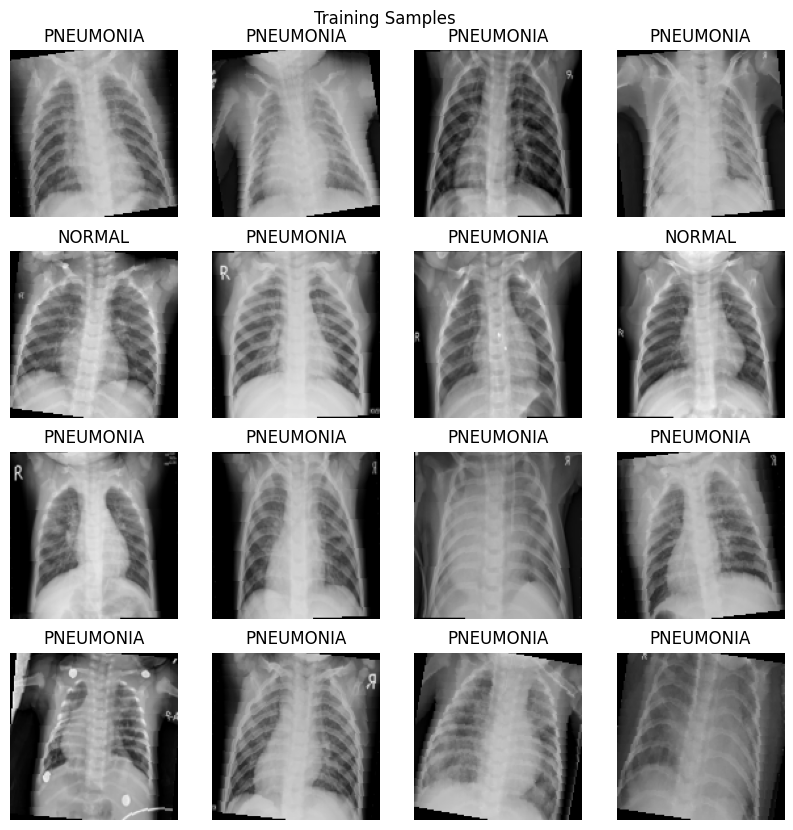

In [ ]:
idx_to_class = {v: k for k, v in class_to_idx.items()}

def unnormalize(img_tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    img = img_tensor.clone()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    return torch.clamp(img, 0, 1)

plt.figure(figsize=(10, 10))
rows, cols = 4, 4

for i in range(rows * cols):
    idx = random.randint(0, len(train_dataset) - 1)
    img, label = train_dataset[idx]

    img_show = (
        unnormalize(img)
        .permute(1, 2, 0)
        .cpu()
        .numpy()
    )

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_show)
    plt.axis("off")
    plt.title(idx_to_class[int(label)])

plt.suptitle("Training Samples", y=0.92)
plt.show()

### **7- DataLoaders**

Batch size 32 provides a balance between training speed, gradient stability, and memory usage. shuffle=True in training prevents the model from memorizing data order and improves generalization, while shuffle=False in validation ensures consistent and reproducible results.





In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False
)


In [ ]:
images, labels = next(iter(train_loader))

print("Images shape:", images.shape)
print("Labels:", labels.shape, labels.dtype)


Images shape: torch.Size([32, 3, 128, 128])
Labels: torch.Size([32]) torch.int64


##**8- CNN Architecture**

The proposed CNN model consists of four convolutional layers, each followed by ReLU activation and max pooling, enabling hierarchical feature extraction from chest X-ray images.

The convolutional blocks progressively increase the number of channels (3 → 8 → 16 → 32 → 64) to capture low-level to high-level visual patterns such as edges, textures, and lung abnormalities.

Layers:
4 Convolutional layers

4 MaxPooling layers

2 Fully Connected layers

1 Dropout layer


**Activation Functions:**

ReLU is used after each convolutional and fully connected layer to introduce non-linearity, allowing the model to learn complex visual patterns efficiently while avoiding the vanishing gradient problem. The final layer does not use an activation function, as raw logits are required by CrossEntropyLoss.

**Tensor Explanation:**

Raw chest X-ray images are initially loaded as PIL images. Using ToTensor(), each image is converted into a PyTorch tensor with shape (C, H, W),

where: C = number of channels (3)

H, W = image height and width (128 × 128)

Pixel values are scaled from [0, 255] to [0, 1], then normalized using ImageNet statistics to stabilize training and accelerate convergence.

**Training Configuration:**

**1- Loss Function:** CrossEntropyLoss() --> Internally handles the softmax operation.

**2- Optimizer:** provide faster and more stable convergence, weight decay acts as L2 regularization to reduce overfitting by penalizing large weights.
with the following parameters :
lr=1e-3,
weight_decay=1e-4

**3- Learning Rate Scheduler:** ReduceLROnPlateau --> Automatically reduces the learning rate when validation loss plateaus, allowing finer weight updates in later epochs.

**4- Dropout:** Randomly deactivates 25% of neurons during training to improve generalization.

**5- Early Stopping:** Training stops if validation F1-score does not improve for 5 consecutive epochs, preventing overfitting and saving computational resources.


In [ ]:
class CNN_XRay(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.25):
        super().__init__()
        self.dropout_rate = dropout_rate

        self.conv1 = nn.Conv2d(3, 8,  kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16,32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32,64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)

        with torch.no_grad():
            dummy = torch.zeros(1,3,IMG_SIZE,IMG_SIZE)
            x = self._forward_features(dummy)
            self.flatten_dim = x.view(1,-1).shape[1]

        self.fc1 = nn.Linear(self.flatten_dim, 100)
        self.fc2 = nn.Linear(100, num_classes)

    def _forward_features(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        logits = self.fc2(x)
        return logits

model = CNN_XRay(num_classes=len(classes))
summary(model, input_size=(3, IMG_SIZE, IMG_SIZE))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]             224
         MaxPool2d-2            [-1, 8, 64, 64]               0
            Conv2d-3           [-1, 16, 64, 64]           1,168
         MaxPool2d-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
         MaxPool2d-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          18,496
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Linear-9                  [-1, 100]         409,700
           Linear-10                    [-1, 2]             202
Total params: 434,430
Trainable params: 434,430
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 2.34
Params size (MB): 1.66
Estimated T

##**9- Training components**

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2
)

BEST_PATH = "chest_Xray_best_state_dict.pt"


##**10- Train/Eval helpers**


In [ ]:
def _f1_avg():
    # إذا ثنائي => binary، إذا متعدد => macro
    return 'binary' if len(classes)==2 else 'macro'

def train_one_epoch(model, loader):
    model.train()
    losses=[]
    all_true, all_pred = [], []

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        preds = torch.argmax(logits, dim=1)
        all_true.extend(y.detach().cpu().numpy())
        all_pred.extend(preds.detach().cpu().numpy())

    avg_loss = float(np.mean(losses))
    acc = accuracy_score(all_true, all_pred)
    f1  = f1_score(all_true, all_pred, average=_f1_avg())
    return avg_loss, acc, f1

@torch.no_grad()
def eval_one_epoch(model, loader):
    model.eval()
    losses=[]
    all_true, all_pred = [], []

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        loss = criterion(logits, y)

        losses.append(loss.item())

        preds = torch.argmax(logits, dim=1)
        all_true.extend(y.detach().cpu().numpy())
        all_pred.extend(preds.detach().cpu().numpy())

    avg_loss = float(np.mean(losses))
    acc = accuracy_score(all_true, all_pred)
    f1  = f1_score(all_true, all_pred, average=_f1_avg())
    return avg_loss, acc, f1


## **11) Training Loop**

In [ ]:
EPOCHS = 20
patience = 5
min_delta = 1e-3
counter = 0

history = {
    "train_loss": [], "val_loss": [],
    "train_acc":  [], "val_acc":  [],
    "train_f1":   [], "val_f1":   []
}

best_val_f1 = -1.0
best_wts = copy.deepcopy(model.state_dict())

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, tr_f1 = train_one_epoch(model, train_loader)
    va_loss, va_acc, va_f1 = eval_one_epoch(model, val_loader)

    scheduler.step(va_loss)

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(va_acc)
    history["train_f1"].append(tr_f1)
    history["val_f1"].append(va_f1)

    improved = (va_f1 - best_val_f1) > min_delta
    if improved:
        best_val_f1 = va_f1
        best_wts = copy.deepcopy(model.state_dict())
        torch.save(best_wts, BEST_PATH)
        counter = 0
    else:
        counter += 1

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train_loss {tr_loss:.4f} acc {tr_acc:.4f} f1 {tr_f1:.4f} | "
          f"val_loss {va_loss:.4f} acc {va_acc:.4f} f1 {va_f1:.4f}")

    if counter >= patience:
        print(f"Early stopping at epoch {epoch} (best val_f1={best_val_f1:.4f})")
        break

model.load_state_dict(best_wts)


Epoch 01/20 | train_loss 0.1364 acc 0.9480 f1 0.9646 | val_loss 0.1312 acc 0.9556 f1 0.9700
Epoch 02/20 | train_loss 0.1259 acc 0.9510 f1 0.9667 | val_loss 0.1446 acc 0.9522 f1 0.9679
Epoch 03/20 | train_loss 0.1070 acc 0.9571 f1 0.9708 | val_loss 0.1177 acc 0.9613 f1 0.9736
Epoch 04/20 | train_loss 0.1091 acc 0.9576 f1 0.9711 | val_loss 0.1067 acc 0.9613 f1 0.9736
Epoch 05/20 | train_loss 0.1062 acc 0.9580 f1 0.9714 | val_loss 0.0963 acc 0.9670 f1 0.9774
Epoch 06/20 | train_loss 0.1130 acc 0.9595 f1 0.9724 | val_loss 0.1072 acc 0.9647 f1 0.9760
Epoch 07/20 | train_loss 0.0985 acc 0.9651 f1 0.9762 | val_loss 0.1085 acc 0.9601 f1 0.9729
Epoch 08/20 | train_loss 0.1047 acc 0.9649 f1 0.9761 | val_loss 0.0984 acc 0.9658 f1 0.9767
Epoch 09/20 | train_loss 0.1000 acc 0.9617 f1 0.9739 | val_loss 0.0937 acc 0.9704 f1 0.9797
Epoch 10/20 | train_loss 0.0861 acc 0.9673 f1 0.9777 | val_loss 0.0975 acc 0.9715 f1 0.9805
Epoch 11/20 | train_loss 0.0952 acc 0.9661 f1 0.9769 | val_loss 0.1024 acc 0.963

<All keys matched successfully>

In [ ]:
print("Train size:", len(train_dataset))
print("Val size  :", len(val_dataset))
print("Classes   :", classes)


Train size: 4099
Val size  : 878
Classes   : ['NORMAL', 'PNEUMONIA']


##**12- Loss/Acc/F1 Plot curves**

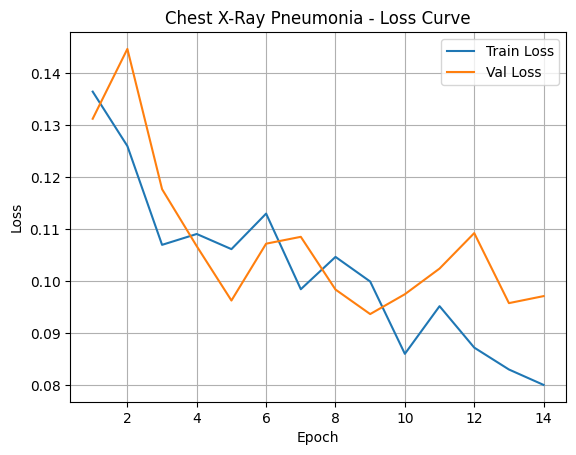

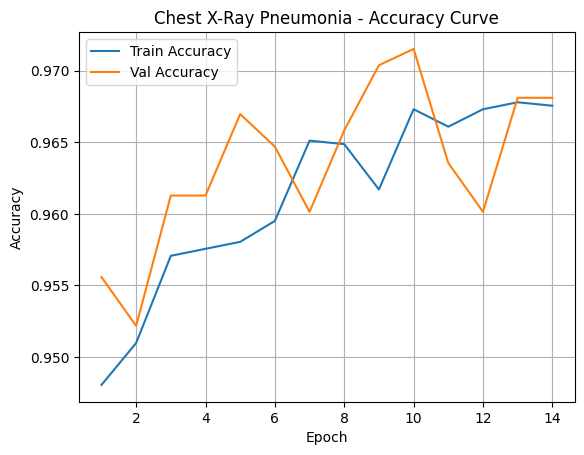

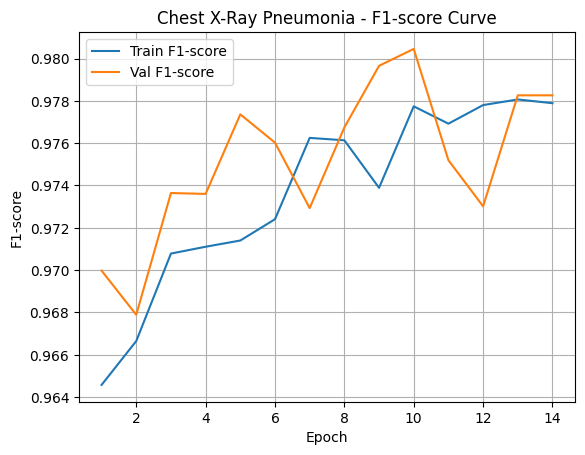

In [ ]:
# ---- Plot settings ----
epochs = np.arange(1, len(history["train_loss"]) + 1)

# -------- Loss --------
plt.figure()
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.title("Chest X-Ray Pneumonia - Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# -------- Accuracy --------
plt.figure()
plt.plot(epochs, history["train_acc"], label="Train Accuracy")
plt.plot(epochs, history["val_acc"], label="Val Accuracy")
plt.title("Chest X-Ray Pneumonia - Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# -------- F1-score --------
plt.figure()
plt.plot(epochs, history["train_f1"], label="Train F1-score")
plt.plot(epochs, history["val_f1"], label="Val F1-score")
plt.title("Chest X-Ray Pneumonia - F1-score Curve")
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.legend()
plt.grid(True)
plt.show()


## 13- Evaluation: Validation + Test (Classification Report + Confusion Matrix)


In [ ]:
model.load_state_dict(torch.load(BEST_PATH, map_location=device))
model.eval()

@torch.no_grad()
def get_true_pred(model, loader):
    all_true, all_pred = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_true.extend(y.numpy())
        all_pred.extend(preds)
    return np.array(all_true), np.array(all_pred)

print("Classes:", classes)

# ---- Validation ----
y_true_val, y_pred_val = get_true_pred(model, val_loader)
print("\nValidation classification report:\n")
print(classification_report(y_true_val, y_pred_val, target_names=classes))

# ---- Test ----
y_true_test, y_pred_test = get_true_pred(model, test_loader)
print("\nTest classification report:\n")
print(classification_report(y_true_test, y_pred_test, target_names=classes))


Classes: ['NORMAL', 'PNEUMONIA']

Validation classification report:

              precision    recall  f1-score   support

      NORMAL       0.96      0.93      0.95       243
   PNEUMONIA       0.97      0.99      0.98       635

    accuracy                           0.97       878
   macro avg       0.97      0.96      0.96       878
weighted avg       0.97      0.97      0.97       878


Test classification report:

              precision    recall  f1-score   support

      NORMAL       0.94      0.93      0.93       243
   PNEUMONIA       0.97      0.98      0.97       636

    accuracy                           0.96       879
   macro avg       0.96      0.95      0.95       879
weighted avg       0.96      0.96      0.96       879



## 14- Confusion Matrices (Validation + Test)


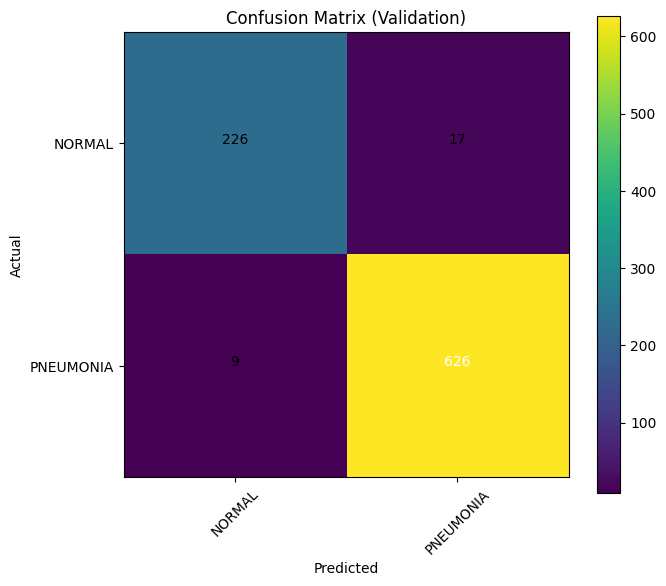

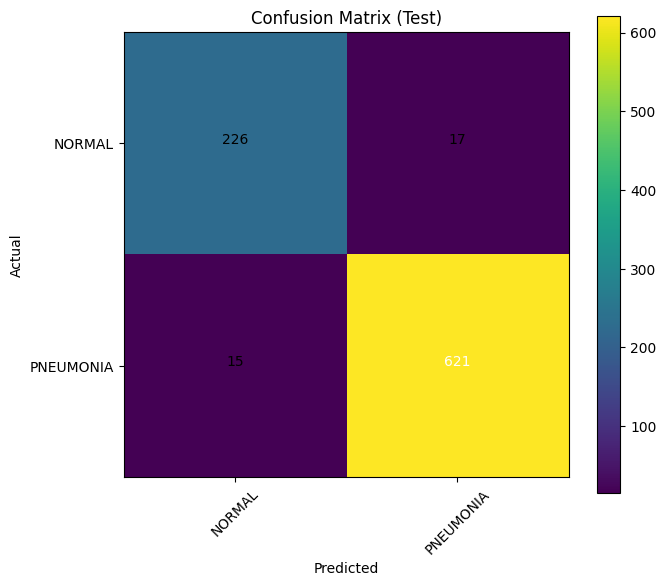

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(7, 6))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

# Validation CM
cm_val = confusion_matrix(y_true_val, y_pred_val)
plot_confusion_matrix(cm_val, classes, title="Confusion Matrix (Validation)")

# Test CM
cm_test = confusion_matrix(y_true_test, y_pred_test)
plot_confusion_matrix(cm_test, classes, title="Confusion Matrix (Test)")


 ## **14- Save model**

In [ ]:
STATE_DICT_PATH = "ChestXray_Pneumonia_model_state_dict.pt"
FULL_MODEL_PATH = "ChestXray_Pneumonia_model_full.pt"

torch.save(model.state_dict(), STATE_DICT_PATH)
torch.save(model, FULL_MODEL_PATH)